<a href="https://colab.research.google.com/github/raulbenitez/NEUROIMAGING_AI/blob/main/fmri_decoding_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EXAMPLE Taken From https://nilearn.github.io/auto_examples/07_advanced/plot_advanced_decoding_scikit.html


Affine examples:

https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py

https://nilearn.github.io/auto_examples/01_plotting/plot_visualization.html#sphx-glr-auto-examples-01-plotting-plot-visualization-py


In [2]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 25.9 MB/s 


# Load Haxby data

In [4]:
# The :func:`nilearn.datasets.fetch_haxby` function will download the
# Haxby dataset composed of fmri images in a Niimg, a spatial mask and a text
# document with label of each image
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# Access to 1st subject data:
mask_filename = haxby_dataset.mask_vt[0]
fmri_filename = haxby_dataset.func[0]

# Loading the behavioral labels
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
behavioral.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


In [14]:
haxby_dataset

{'anat': ['/root/nilearn_data/haxby2001/subj2/anat.nii.gz'],
 'description': b'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distributed and overlapping\nresponse patterns.\n\nContent\n-------\nThe "simple" dataset includes\n    :\'func\': Nifti images with bold data\n    :\'session_target\': Text file containing session data\n    :\'mask\': Nifti images with employed mask\n    :\'session\': Text file with condition labels\n\n\nThe full dataset additionally includes\n    :\'anat\': Nifti images with anatomical image\n    :\'func\': Nifti images with bold data\n    :\'mask_vt\': Nifti images with mask for ventral visual/temporal cortex\n    :\'mask_face\': Nifti images with face-reponsive brain regions\n    :\'mask_house\': Nifti images with house-reponsive brain regions\n    :\'mask_face_little

In [6]:
behavioral.shape

(1452, 2)

Visualize anatomical image of the 1st subject

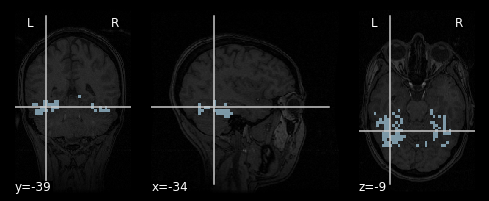

In [25]:
# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],cmap='Paired')

Visualize average fmri response of 1st subject

Because fmri data are 4D (they consist of many 3D EPI images), we cannot plot them directly using nilearn.plotting.plot_epi (which accepts just 3D input). Here we are using nilearn.image.mean_img to extract a single 3D EPI image from the fmri data.

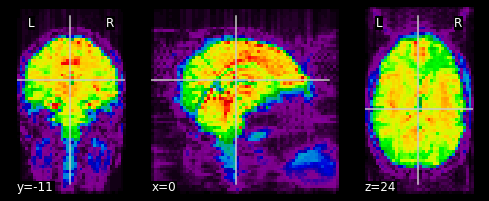

In [22]:
from nilearn.image.image import mean_img

# Compute the mean EPI of the first subject: we do the mean along the axis 3, which is time
mean_haxby = mean_img(fmri_filename)

from nilearn.plotting import plot_epi, show
plot_epi(mean_haxby)

Interactive plot for inspection


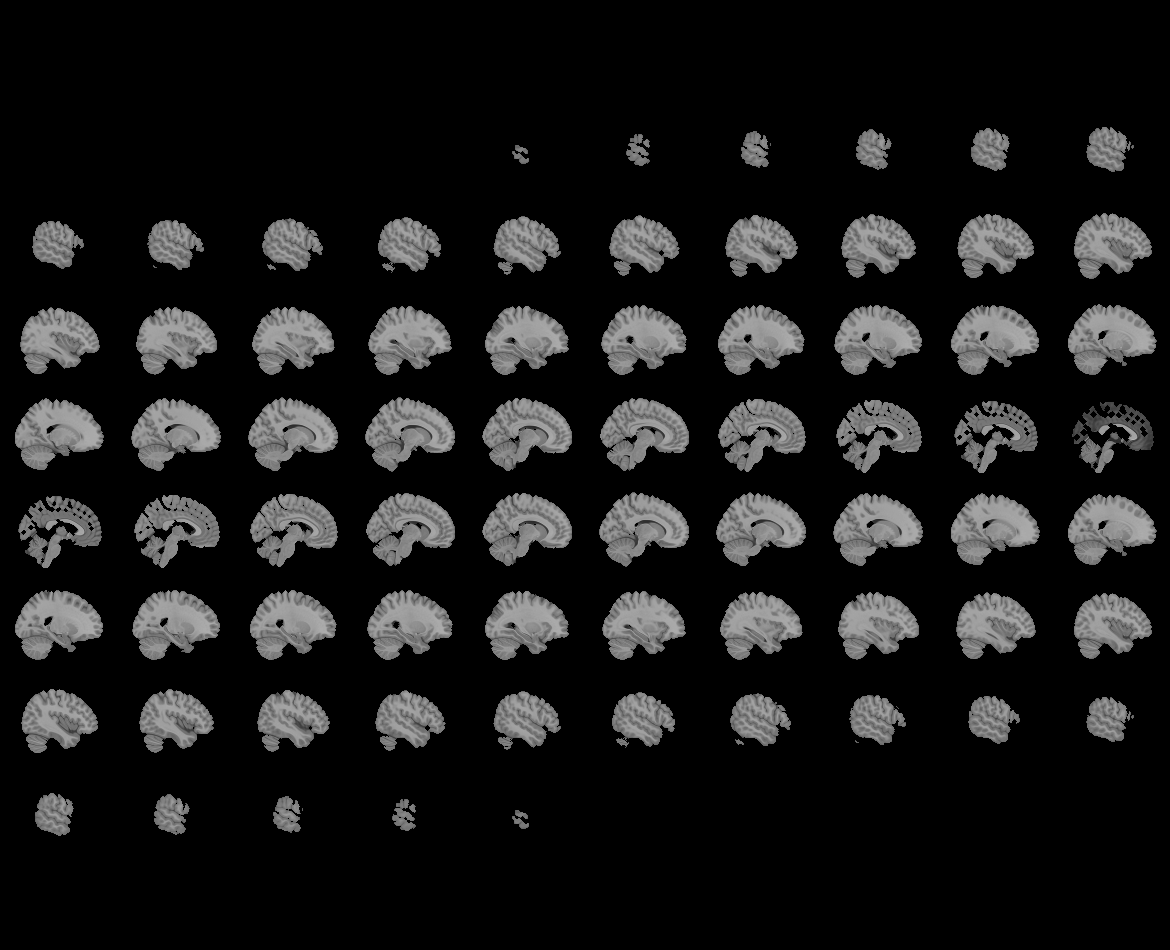
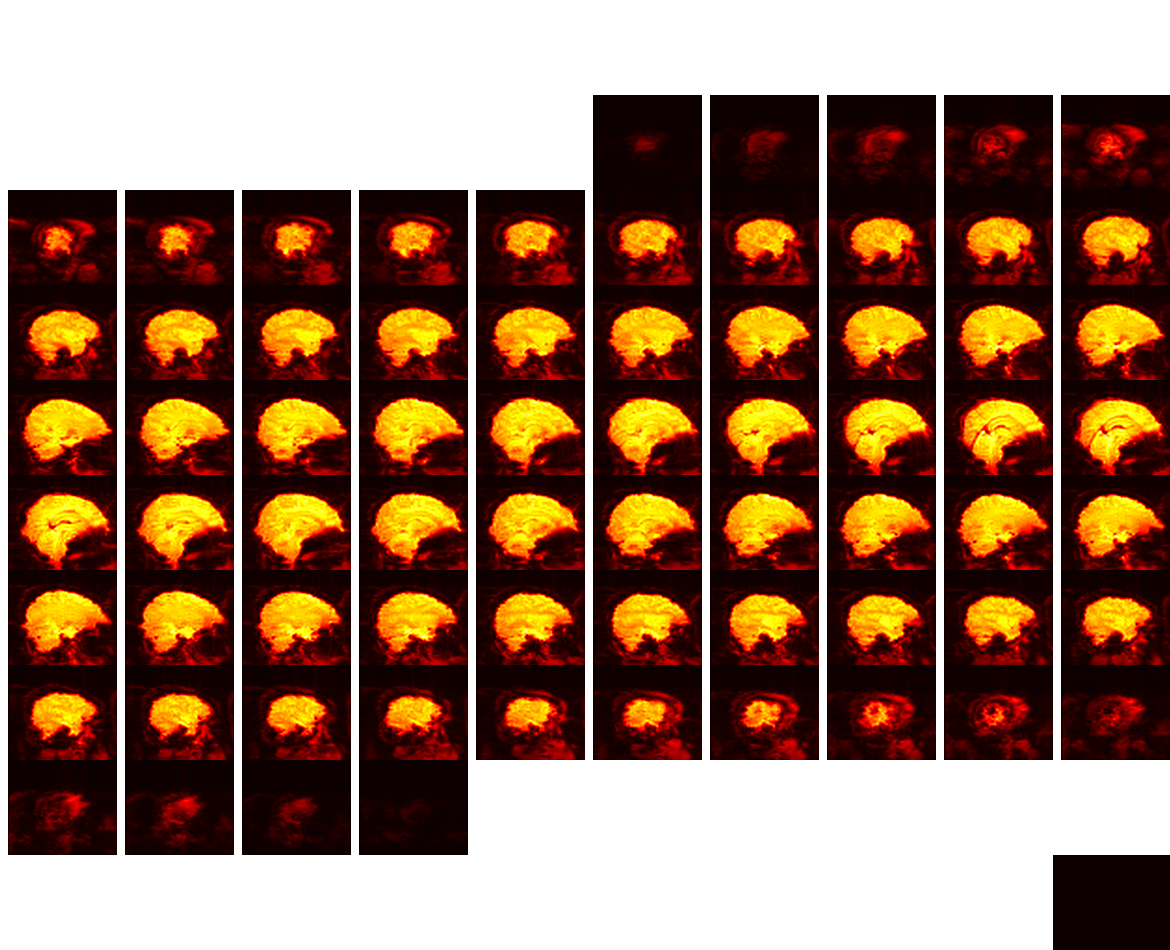

In [23]:
from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_haxby, threshold=None)

# Filter data

Filter only fmri responses from two stimulation conditions (cat and face):

In [5]:
from nilearn.image import index_img
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'cat'])
fmri_niimgs = index_img(fmri_filename, condition_mask)
conditions = conditions[condition_mask]
# Convert to numpy array
conditions = conditions.values
session_label = behavioral['chunks'][condition_mask]

In [29]:
print('number of images: {}'.format(conditions.shape[0]))
conditions    

number of images: 216


array(['face', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'cat', 'cat',
      

In [30]:
print(session_label.shape)
session_label

(216,)


21       0
22       0
23       0
24       0
25       0
        ..
1427    11
1428    11
1429    11
1430    11
1431    11
Name: chunks, Length: 216, dtype: int64

# Feature Extraction 1: Relevant voxels

To use a scikit-learn estimator on brain images, you should first mask the data using a nilearn.input_data.NiftiMasker to extract only the voxels inside the mask of interest, and transform 4D input fMRI data to 2D arrays(shape=(n_timepoints, n_voxels)) that estimators can work on.

In [10]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, sessions=session_label,
                     smoothing_fwhm=4, standardize=True,
                     memory="nilearn_cache", memory_level=1)
fmri_masked = masker.fit_transform(fmri_niimgs)

/usr/local/lib/python3.7/dist-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


This will return the features, one per voxel of interest:

In [33]:
print('Number of images: {}, number of voxels: {}'.format(fmri_masked.shape[0],fmri_masked.shape[1]))

Number of images: 216, number of voxels: 464


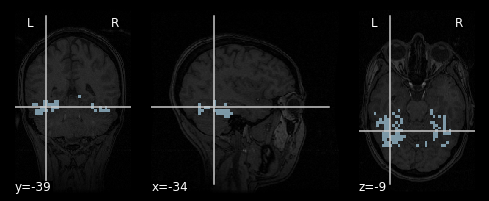

In [41]:
# Let's visualize the voxels of interest using the subject's anatomical image as background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],cmap='Paired')

# Train a SVC classifier

Train a Support Vector Machine Classifier using the extracted voxel features and the conditions as class labels

In [34]:
# Importing a classifier
# ........................
# We can import many predictive models from scikit-learn that can be used in a
# decoding pipelines. They are all used with the same `fit()` and `predict()`
# functions. Let's define a `Support Vector Classifier <http://scikit-learn.org/stable/modules/svm.html >`_ (or SVC).
from sklearn.svm import SVC
svc = SVC()

In [35]:
from sklearn.model_selection import cross_val_score
# Here `cv=5` stipulates a 5-fold cross-validation
cv_scores = cross_val_score(svc, fmri_masked, conditions, cv=5)
print("SVC accuracy: {:.3f}".format(cv_scores.mean()))

SVC accuracy: 0.823


# Feature Extraction 2: Recursive Feature Elimination (RFE) 

Apply RFE to select the best 50 voxels:

In [42]:
from sklearn.pipeline import Pipeline

# Import it and define your fancy objects
from sklearn.feature_selection import RFE
svc = SVC()
rfe = RFE(SVC(kernel='linear', C=1.), n_features_to_select=50, step=0.25)

# Create a new pipeline, composing the two classifiers `rfe` and `svc`

rfe_svc = Pipeline([('rfe', rfe), ('svc', svc)])

# Recompute the cross-validation score
# cv_scores = cross_val_score(rfe_svc, fmri_masked, target, cv=cv, n_jobs=-1, verbose=1)
# But, be aware that this can take * A WHILE * ...

In [43]:
from sklearn.model_selection import cross_val_score
# Here `cv=5` stipulates a 5-fold cross-validation
cv_scores = cross_val_score(rfe_svc, fmri_masked, conditions, cv=5)
print("SVC accuracy: {:.3f}".format(cv_scores.mean()))

SVC accuracy: 0.860
